# Реализовать синтезирование лиц из LFW с помощью DCGAN.
 Библиотеки: [Python, Tensorflow]

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

## Загрузка и подготовка датасета LFW

In [2]:
train_ds, ds_info = tfds.load(
    'lfw',
    with_info=True,
    split='train'
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/13233 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/lfw/0.1.0.incomplete47GYI5/lfw-train.tfrecord*...:   0%|          | 0/13233 [0…

Dataset lfw downloaded and prepared to ~/tensorflow_datasets/lfw/0.1.0. Subsequent calls will reuse this data.


In [3]:
ds_info

tfds.core.DatasetInfo(
    name='lfw',
    full_name='lfw/0.1.0',
    description="""
    Labeled Faces in the Wild:
            A Database for Studying Face Recognition in
            Unconstrained Environments
    """,
    homepage='http://vis-www.cs.umass.edu/lfw',
    data_path='~/tensorflow_datasets/lfw/0.1.0',
    file_format=tfrecord,
    download_size=172.20 MiB,
    dataset_size=180.28 MiB,
    features=FeaturesDict({
        'image': Image(shape=(250, 250, 3), dtype=tf.uint8),
        'label': Text(shape=(), dtype=tf.string),
    }),
    supervised_keys=('label', 'image'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=13233, num_shards=2>,
    },
    citation="""@TechReport{LFWTech,
        author = {Gary B. Huang and Manu Ramesh and Tamara Berg and Erik Learned-Miller},
        title = {Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments},
        institution = {University of Massachusetts, Am

## Визуализация датасета LFW

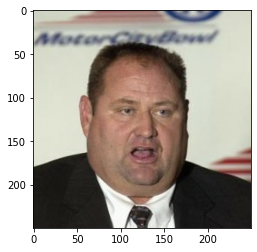

In [4]:
for example in train_ds.take(1):  # Only take a single example
    image = example['image']
    plt.imshow(image.numpy().astype(np.float32)/255)

In [5]:
train_x = [tf.image.rgb_to_grayscale(x['image'].numpy().reshape(250, 250, 3)) for x in train_ds]

In [6]:
train_x[0].shape

TensorShape([250, 250, 1])

In [7]:
len(train_x)

13233

## Deep Convolutional GAN (DCGAN)

In [8]:
generator = tf.keras.Sequential([
    tf.keras.layers.Dense(128*7*7, activation='relu'),
    tf.keras.layers.Reshape((7, 7, 128)),
    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(128, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),    
    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),    
    tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation='tanh'),
])

discriminator = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same'),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.Dropout(0.25),    
    tf.keras.layers.Conv2D(64, kernel_size=3, strides=(2, 2), padding='same'),
    tf.keras.layers.ZeroPadding2D(padding=((0, 1), (0, 1))),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, kernel_size=3, strides=(2, 2), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(256, kernel_size=3, strides=(1, 1), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1),
])

##Подготовка датасета

In [9]:
def prepare(img):
  img = tf.cast(img, tf.float32) / 255.
  return tf.image.resize(img, (28, 28))

In [10]:
INPUT_DIM = 100
NUM_EPOCHS = 50
HALF_BATCH_SIZE = 16
BATCH_SIZE = HALF_BATCH_SIZE * 2
LEARNING_RATE = 0.0002

train_ds = tf.data.Dataset.from_tensor_slices(train_x)
train_ds = train_ds.shuffle(buffer_size=len(train_x))
train_ds = train_ds.map(prepare)
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(HALF_BATCH_SIZE, drop_remainder=True)

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
sigmoid_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [11]:
train_ds

<BatchDataset element_spec=TensorSpec(shape=(16, 28, 28, 1), dtype=tf.float32, name=None)>

In [12]:
def plot_pics(samples):
    fig = plt.figure(figsize=(20, 20))
    num = samples.shape[0]
    for j in range(num):
        ax = fig.add_subplot(6, 8, j+1)
        ax.imshow(samples[j, ...].reshape(28, 28), cmap='gray')
        plt.xticks([]), plt.yticks([])
    plt.show()

[Step  0] D Loss: 0.5622; G Loss: 0.6835


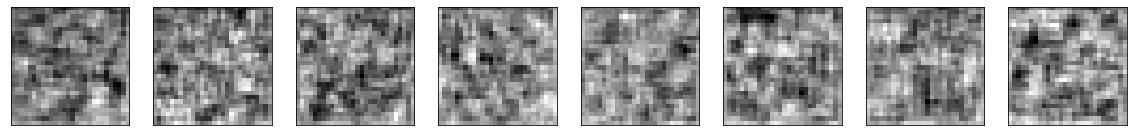

[Step 500] D Loss: 0.4189; G Loss: 2.0440


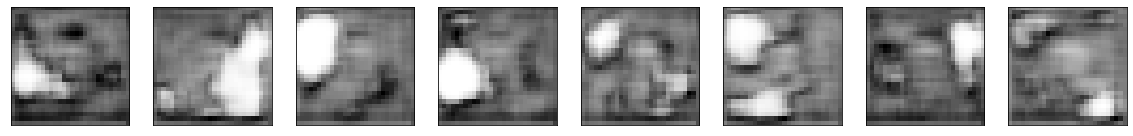

[Step 1000] D Loss: 0.3675; G Loss: 2.6986


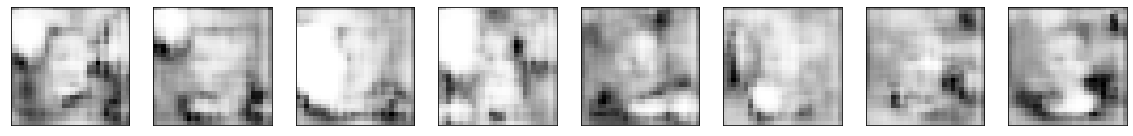

[Step 1500] D Loss: 0.3645; G Loss: 1.3568


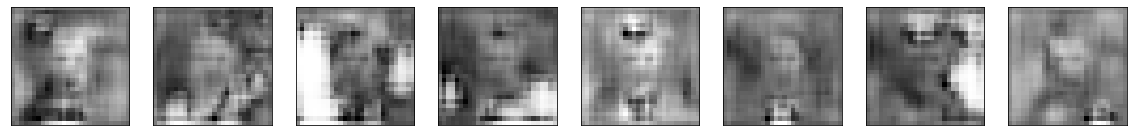

[Step 2000] D Loss: 0.4194; G Loss: 2.2734


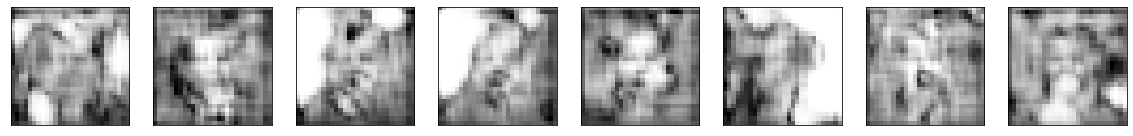

[Step 2500] D Loss: 0.3201; G Loss: 2.9471


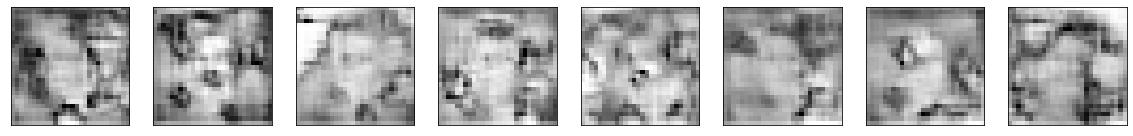

[Step 3000] D Loss: 0.3777; G Loss: 1.3936


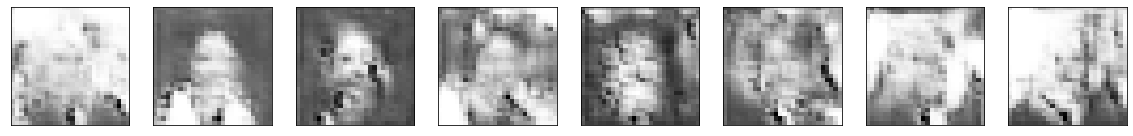

[Step 3500] D Loss: 0.6677; G Loss: 1.1930


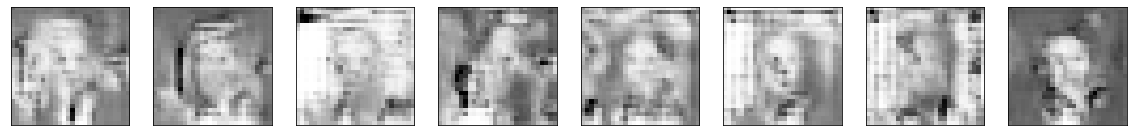

[Step 4000] D Loss: 0.3113; G Loss: 1.6735


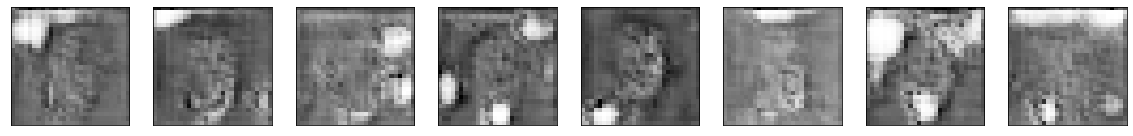

[Step 4500] D Loss: 0.2558; G Loss: 2.0438


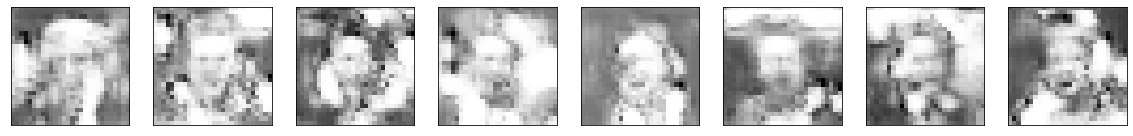

[Step 5000] D Loss: 0.6022; G Loss: 1.3613


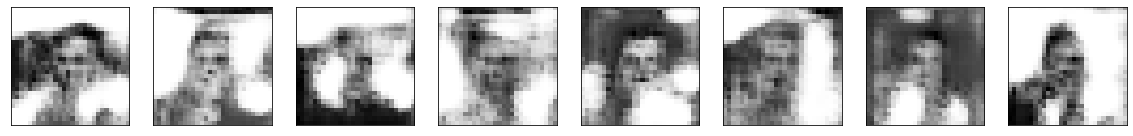

[Step 5500] D Loss: 0.4593; G Loss: 1.5907


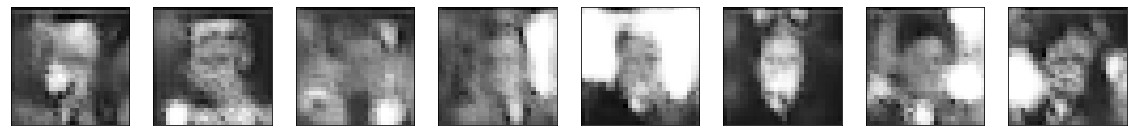

[Step 6000] D Loss: 0.8467; G Loss: 0.8365


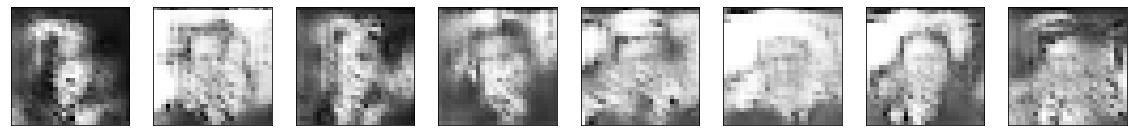

[Step 6500] D Loss: 0.4673; G Loss: 1.1329


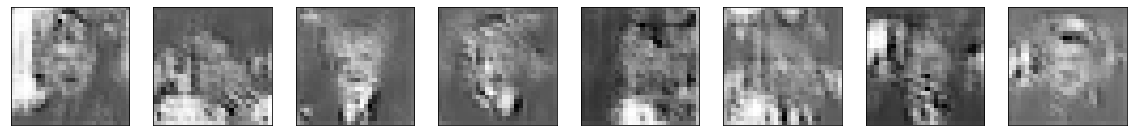

[Step 7000] D Loss: 0.4840; G Loss: 1.5737


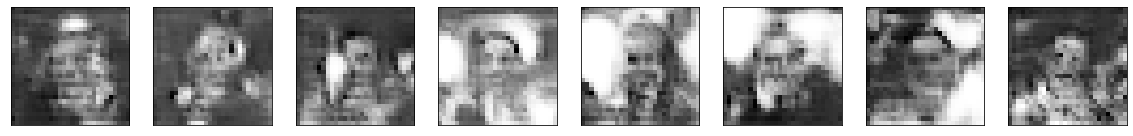

[Step 7500] D Loss: 0.7170; G Loss: 0.7007


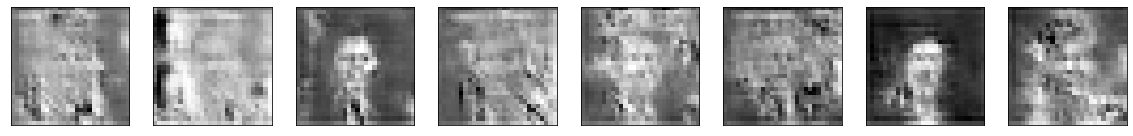

[Step 8000] D Loss: 0.6881; G Loss: 1.1945


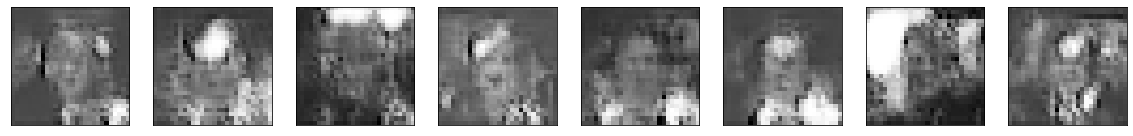

[Step 8500] D Loss: 0.6969; G Loss: 1.2647


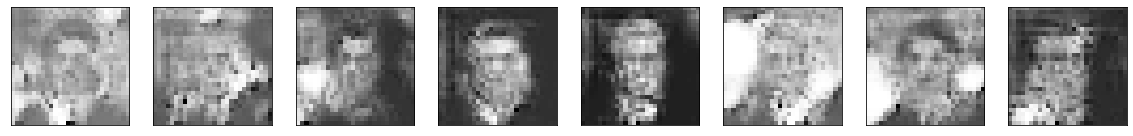

[Step 9000] D Loss: 0.6033; G Loss: 1.1202


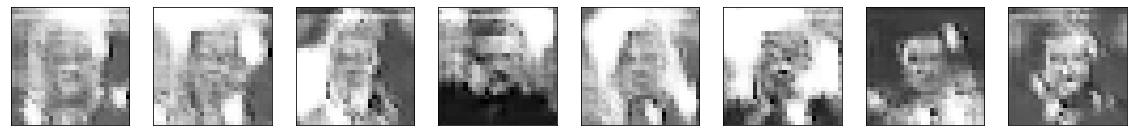

[Step 9500] D Loss: 0.3990; G Loss: 2.0636


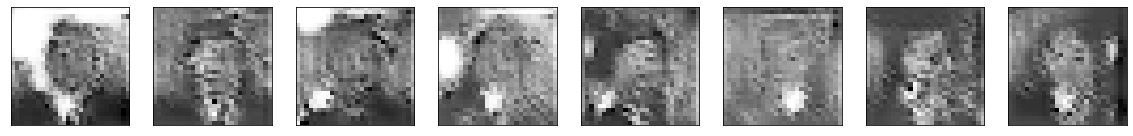

[Step 10000] D Loss: 0.4693; G Loss: 2.3349


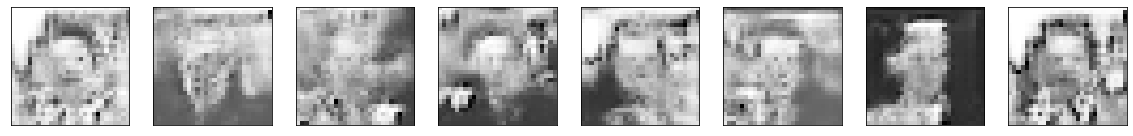

[Step 10500] D Loss: 0.7167; G Loss: 1.8195


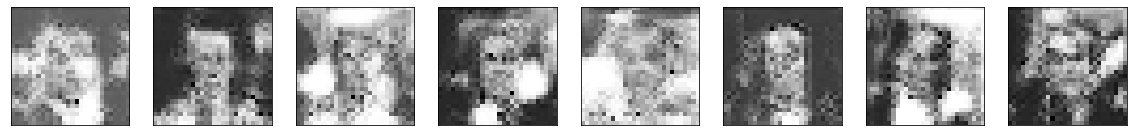

[Step 11000] D Loss: 0.4140; G Loss: 1.5951


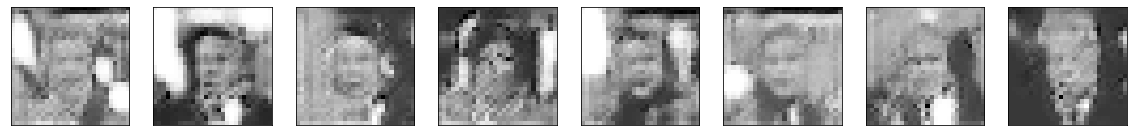

[Step 11500] D Loss: 0.5256; G Loss: 1.8481


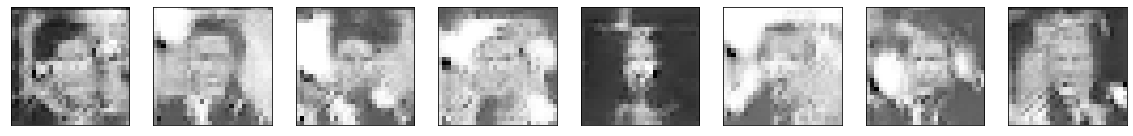

[Step 12000] D Loss: 0.5895; G Loss: 1.5624


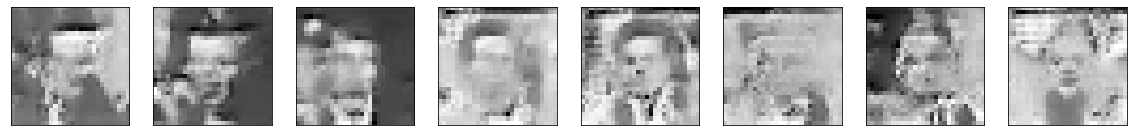

[Step 12500] D Loss: 0.4448; G Loss: 2.4354


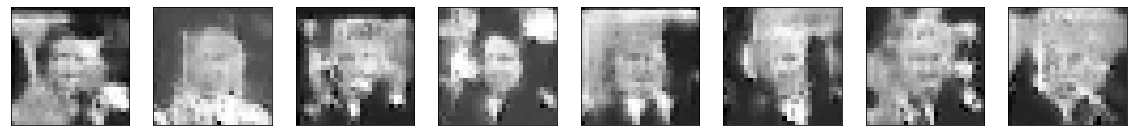

[Step 13000] D Loss: 0.6541; G Loss: 1.6194


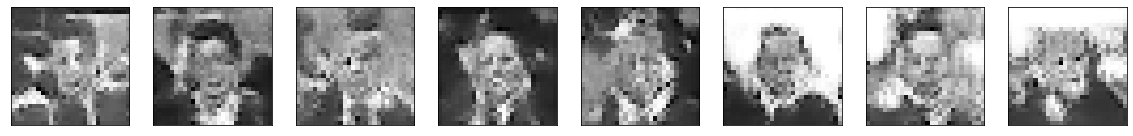

[Step 13500] D Loss: 0.4897; G Loss: 1.5540


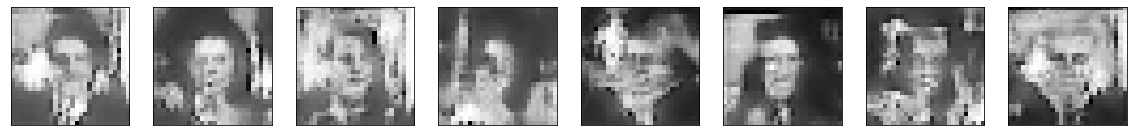

[Step 14000] D Loss: 0.5101; G Loss: 1.4371


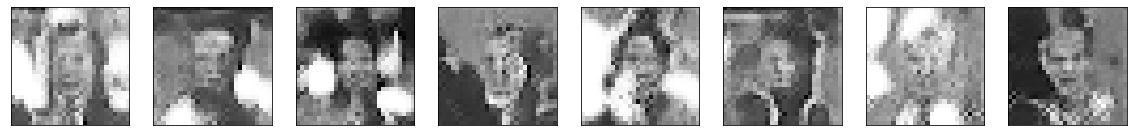

[Step 14500] D Loss: 0.5836; G Loss: 2.1752


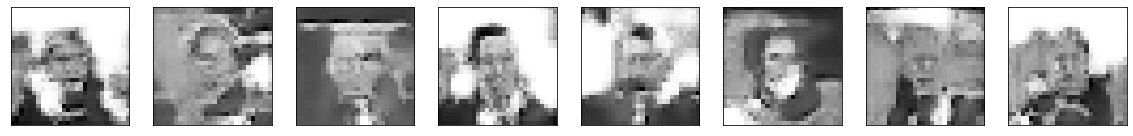

[Step 15000] D Loss: 0.5435; G Loss: 1.0575


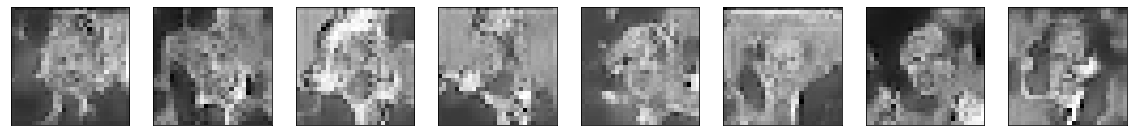

[Step 15500] D Loss: 0.6304; G Loss: 1.5177


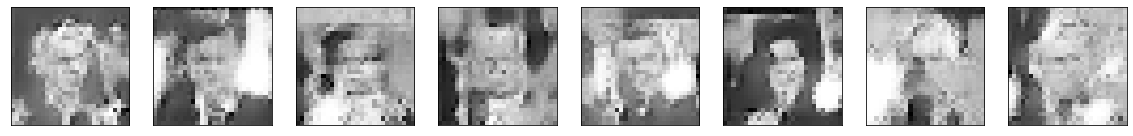

[Step 16000] D Loss: 0.5397; G Loss: 1.3421


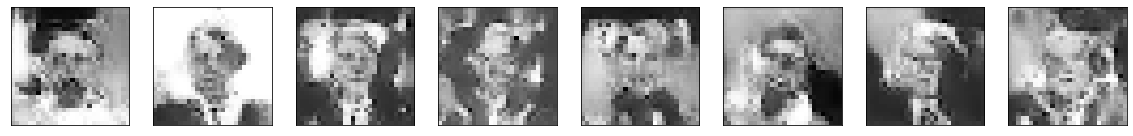

[Step 16500] D Loss: 0.6614; G Loss: 0.8530


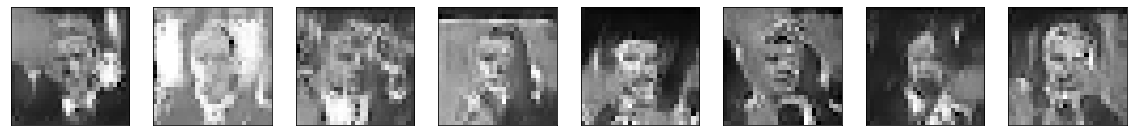

[Step 17000] D Loss: 0.6658; G Loss: 1.2411


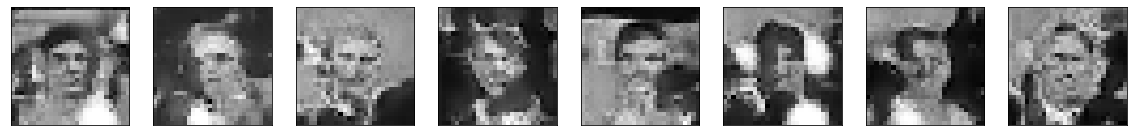

[Step 17500] D Loss: 0.4342; G Loss: 1.0771


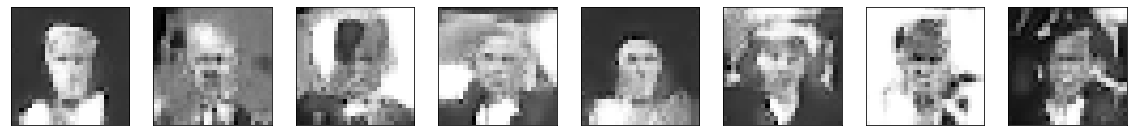

[Step 18000] D Loss: 0.7048; G Loss: 1.2411


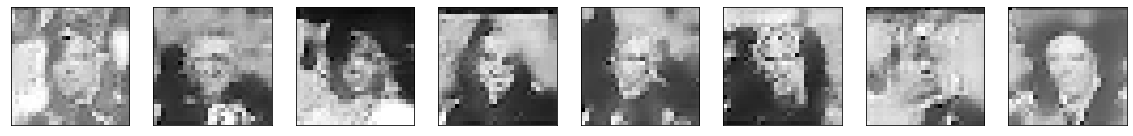

[Step 18500] D Loss: 0.7952; G Loss: 0.8688


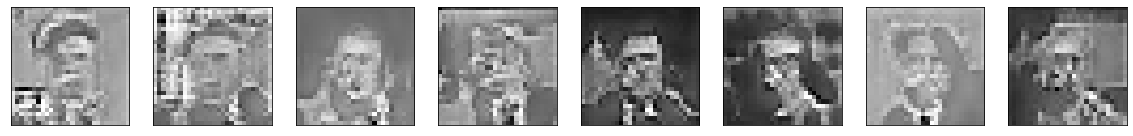

[Step 19000] D Loss: 0.5841; G Loss: 1.1477


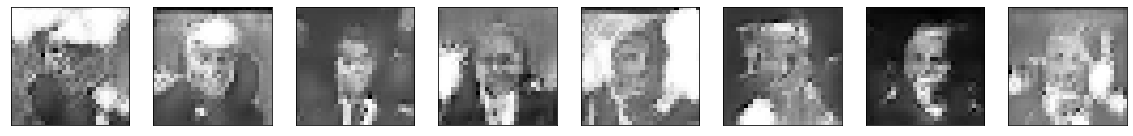

[Step 19500] D Loss: 0.6471; G Loss: 0.7582


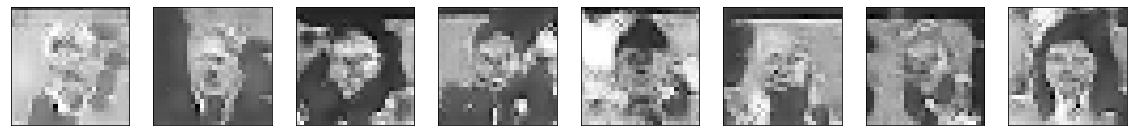

[Step 20000] D Loss: 0.6995; G Loss: 0.8155


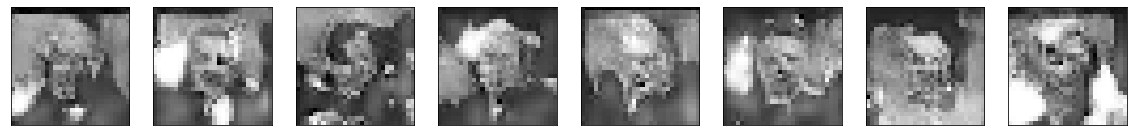

[Step 20500] D Loss: 0.5167; G Loss: 1.1441


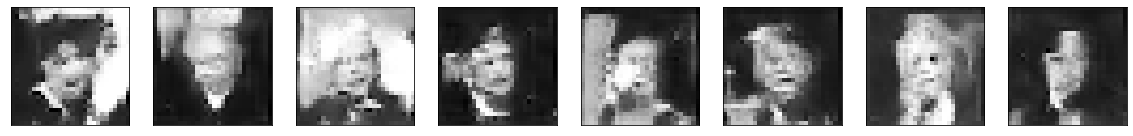

[Step 21000] D Loss: 0.6623; G Loss: 0.7381


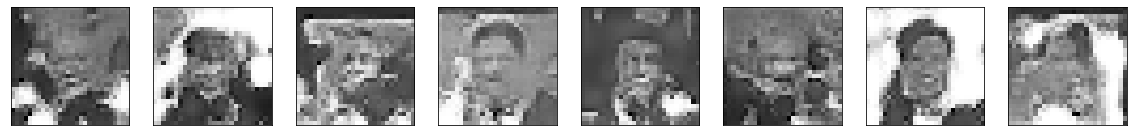

[Step 21500] D Loss: 0.6634; G Loss: 0.8939


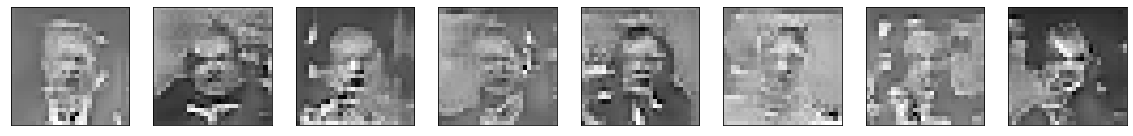

[Step 22000] D Loss: 0.6367; G Loss: 0.9610


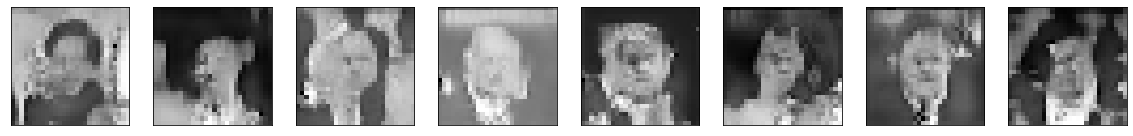

[Step 22500] D Loss: 0.5005; G Loss: 0.8530


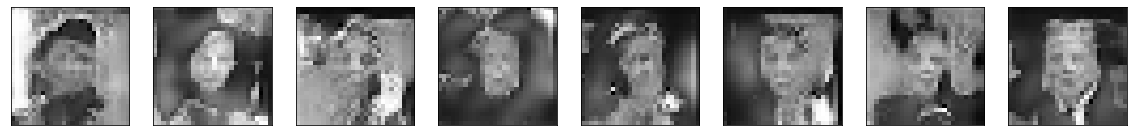

[Step 23000] D Loss: 0.7364; G Loss: 0.6343


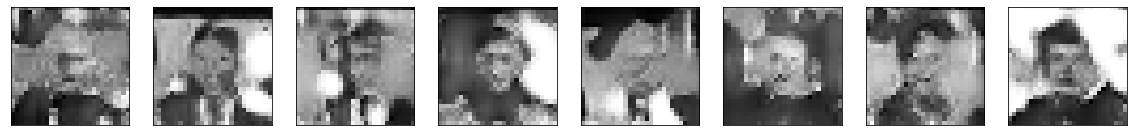

[Step 23500] D Loss: 0.5598; G Loss: 0.9199


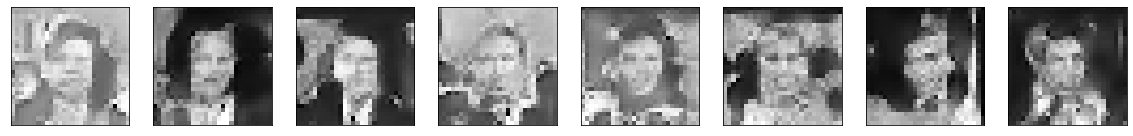

[Step 24000] D Loss: 0.6692; G Loss: 0.7958


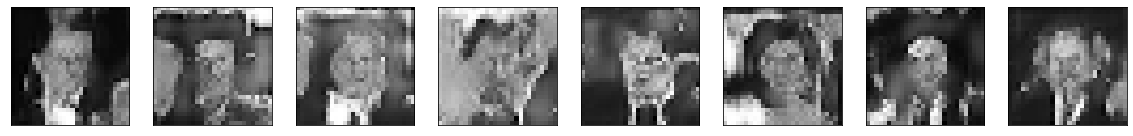

[Step 24500] D Loss: 0.4583; G Loss: 1.5386


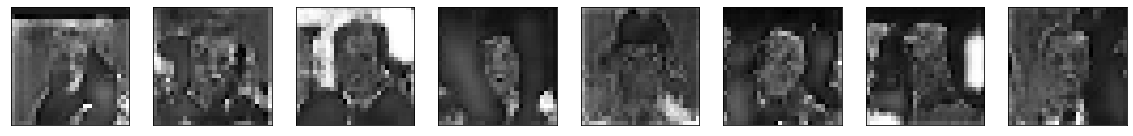

[Step 25000] D Loss: 0.6779; G Loss: 0.7909


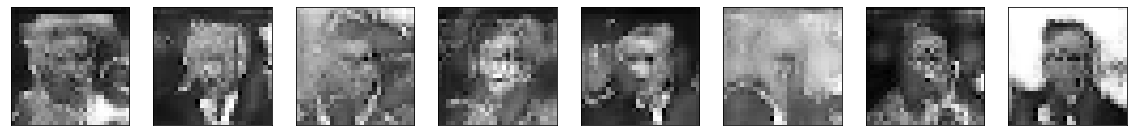

[Step 25500] D Loss: 0.6725; G Loss: 1.1660


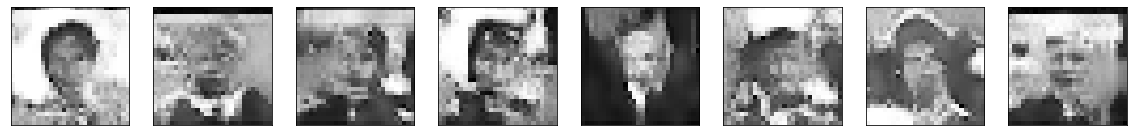

[Step 26000] D Loss: 0.6657; G Loss: 0.9290


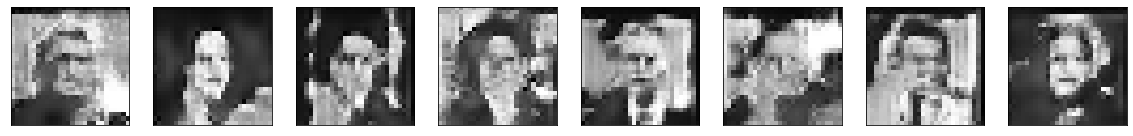

[Step 26500] D Loss: 0.5835; G Loss: 1.0474


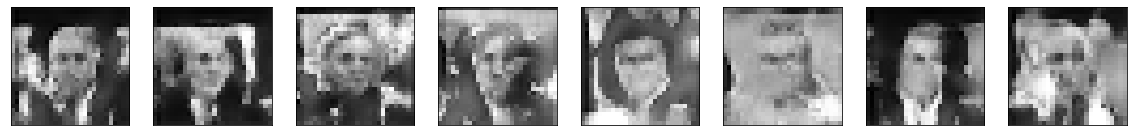

[Step 27000] D Loss: 0.6496; G Loss: 0.5207


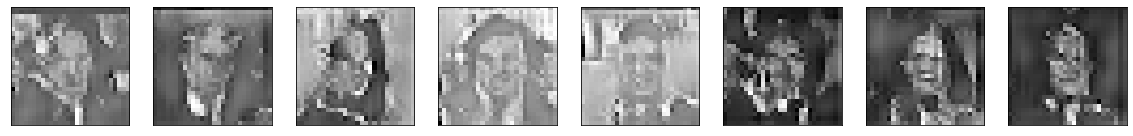

[Step 27500] D Loss: 0.5392; G Loss: 1.3493


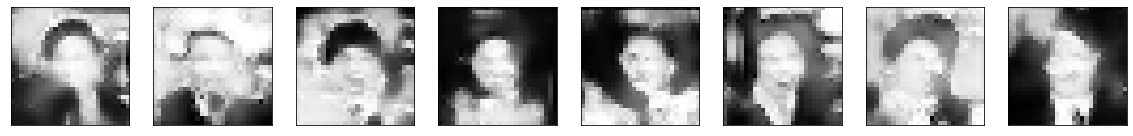

[Step 28000] D Loss: 0.6846; G Loss: 0.5746


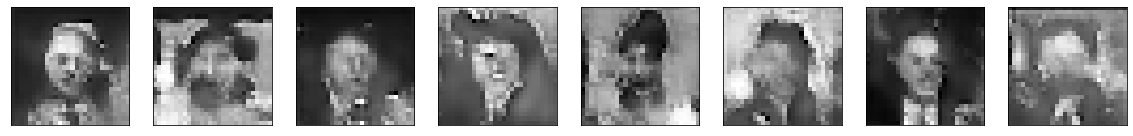

[Step 28500] D Loss: 0.6006; G Loss: 0.9455


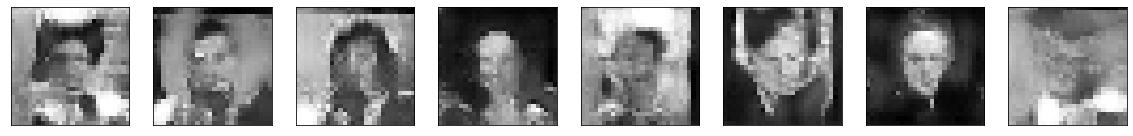

[Step 29000] D Loss: 0.6229; G Loss: 0.5761


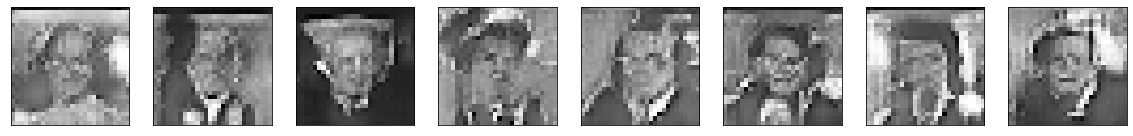

[Step 29500] D Loss: 0.5658; G Loss: 0.9487


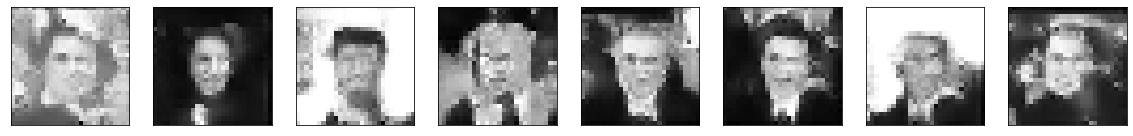

[Step 30000] D Loss: 0.6392; G Loss: 0.7451


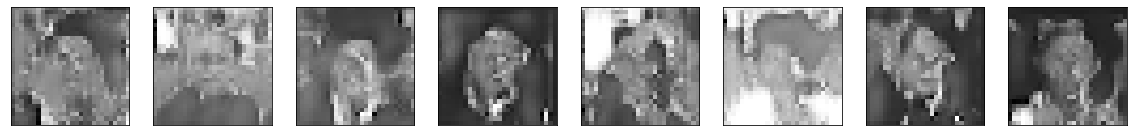

[Step 30500] D Loss: 1.0374; G Loss: 0.4320


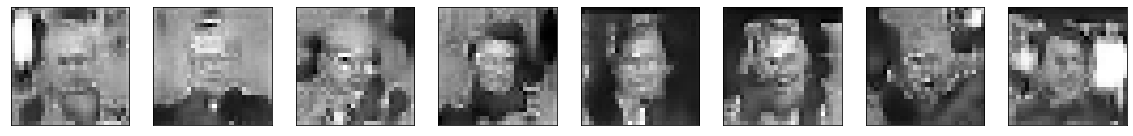

[Step 31000] D Loss: 0.6141; G Loss: 0.9469


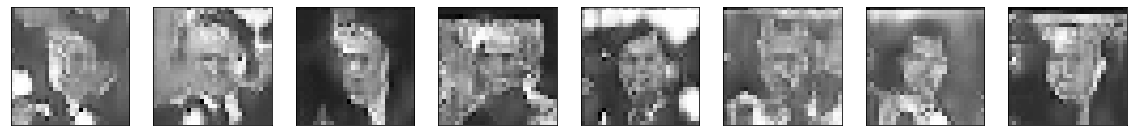

[Step 31500] D Loss: 0.5908; G Loss: 1.0718


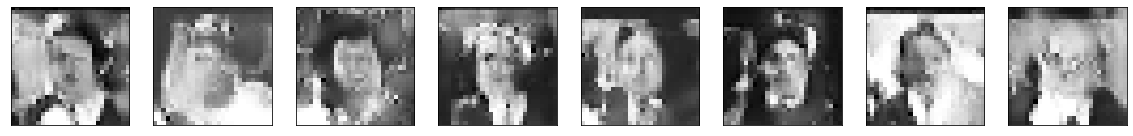

[Step 32000] D Loss: 0.6749; G Loss: 0.6825


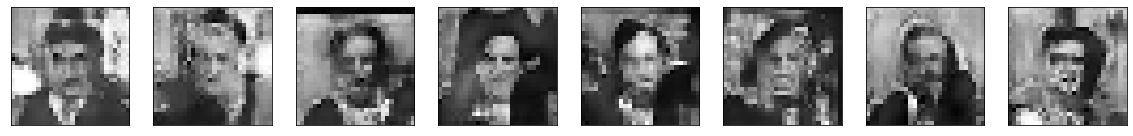

[Step 32500] D Loss: 0.5812; G Loss: 0.7369


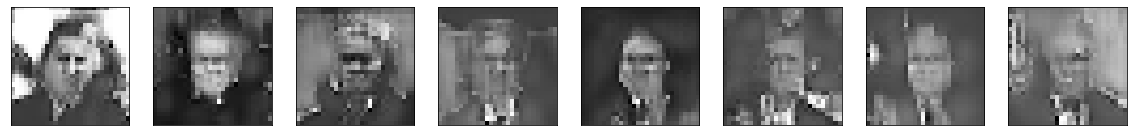

[Step 33000] D Loss: 0.4597; G Loss: 1.1282


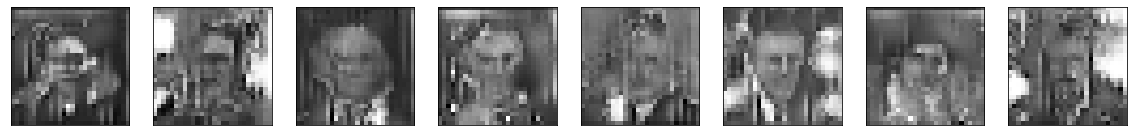

[Step 33500] D Loss: 0.6085; G Loss: 1.0193


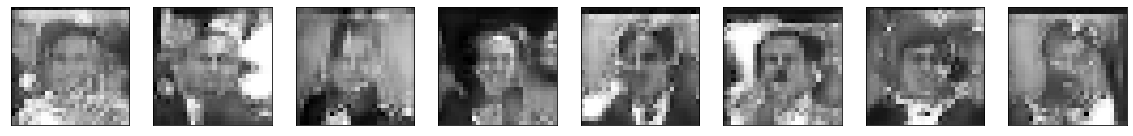

[Step 34000] D Loss: 0.7127; G Loss: 0.8103


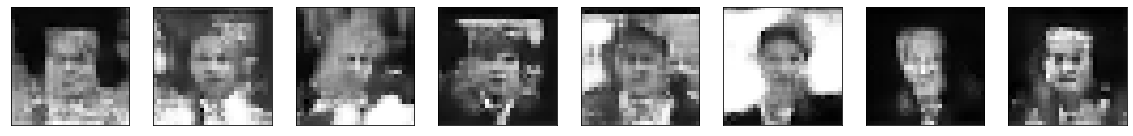

[Step 34500] D Loss: 0.5844; G Loss: 0.8847


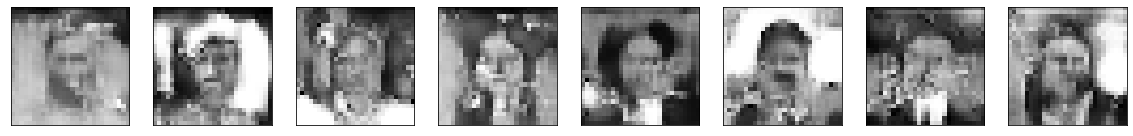

[Step 35000] D Loss: 0.8559; G Loss: 1.0008


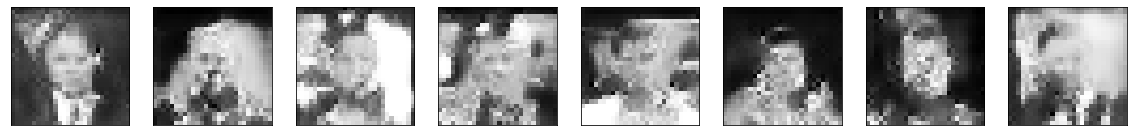

[Step 35500] D Loss: 0.6809; G Loss: 0.9879


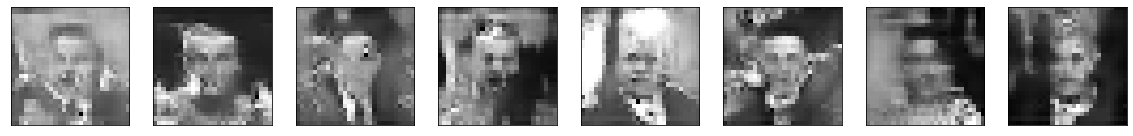

[Step 36000] D Loss: 0.6547; G Loss: 0.9805


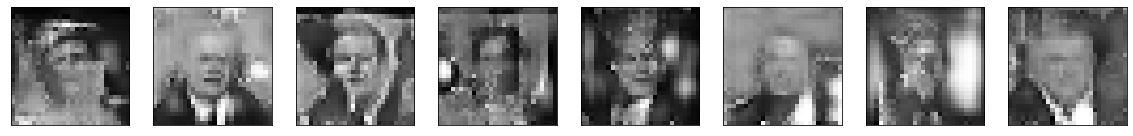

[Step 36500] D Loss: 0.6846; G Loss: 1.1702


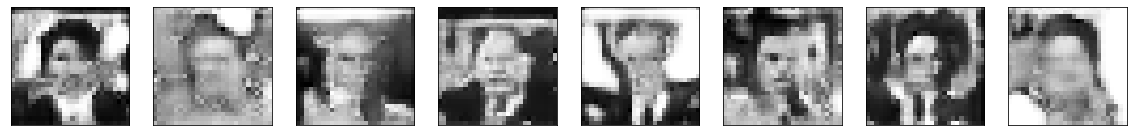

[Step 37000] D Loss: 0.6554; G Loss: 0.7081


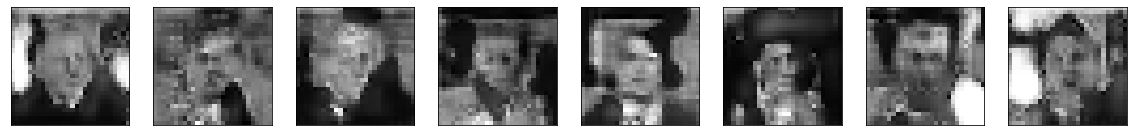

[Step 37500] D Loss: 0.8042; G Loss: 0.8654


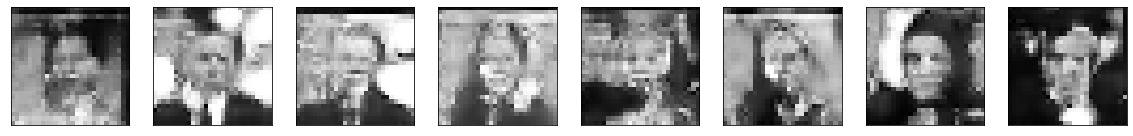

[Step 38000] D Loss: 0.6350; G Loss: 0.7938


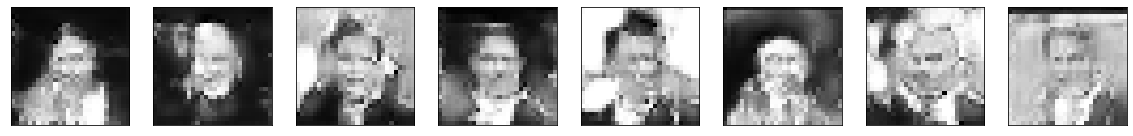

[Step 38500] D Loss: 0.6160; G Loss: 0.6004


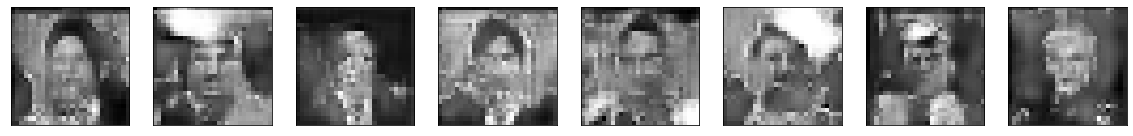

[Step 39000] D Loss: 0.5966; G Loss: 0.7778


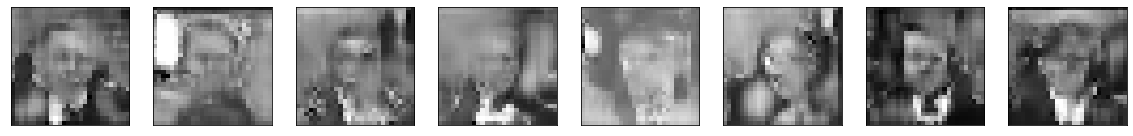

[Step 39500] D Loss: 0.8813; G Loss: 0.4743


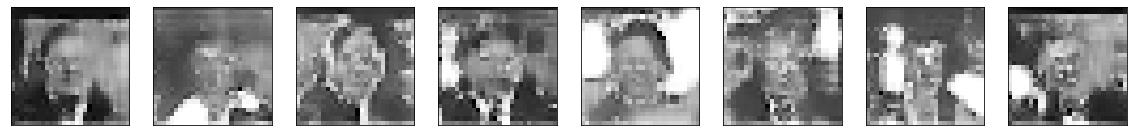

[Step 40000] D Loss: 0.6817; G Loss: 0.7874


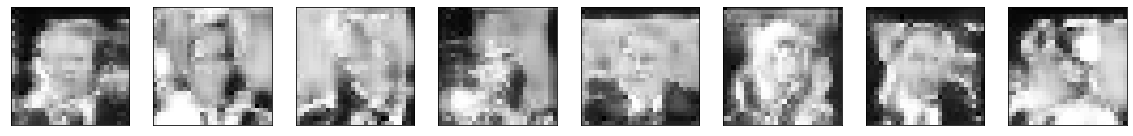

[Step 40500] D Loss: 0.6352; G Loss: 0.9732


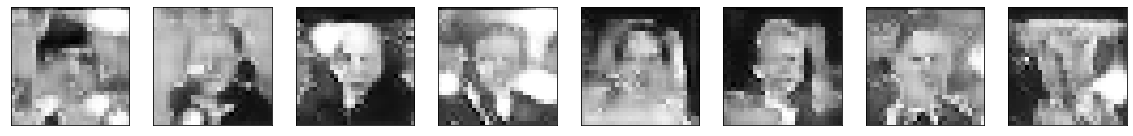

[Step 41000] D Loss: 0.8566; G Loss: 0.5090


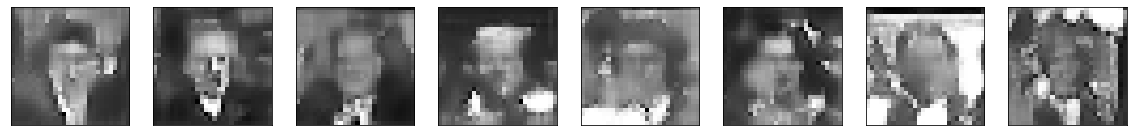

In [13]:
for step, true_images in enumerate(train_ds):
    
    # Train Discriminator
    
    noise = np.random.normal(0, 1, (HALF_BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    syntetic_images = generator.predict(noise)
    x_combined = np.concatenate((
        true_images, 
        syntetic_images))
    y_combined = np.concatenate((
        np.ones((HALF_BATCH_SIZE, 1), np.float32), 
        np.zeros((HALF_BATCH_SIZE, 1), np.float32)))
    
    with tf.GradientTape() as tape:
        logits = discriminator(x_combined, training=True)
        d_loss_value = sigmoid_cross_entropy(y_combined, logits)
    grads = tape.gradient(d_loss_value, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))
    
    # Train Generator
    
    noise = np.random.normal(0, 1, (BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    y_mislabled = np.ones((BATCH_SIZE, 1), np.float32)
    
    with tf.GradientTape() as tape:
        syntetic = generator(noise, training=True)
        logits = discriminator(syntetic, training=False)
        g_loss_value = sigmoid_cross_entropy(y_mislabled, logits)
    grads = tape.gradient(g_loss_value, generator.trainable_variables)
    optimizer.apply_gradients(zip(grads, generator.trainable_variables))
    
    # Check intermediate results
    
    if step % 500 == 0:
        print('[Step %2d] D Loss: %.4f; G Loss: %.4f' % (
            step, d_loss_value.numpy(), g_loss_value.numpy()))
        noise = np.random.normal(0, 1, (8, INPUT_DIM)).astype(np.float32)
        syntetic_images = generator.predict(noise)
        plot_pics(syntetic_images)


## Тестирование свёрточного генератора

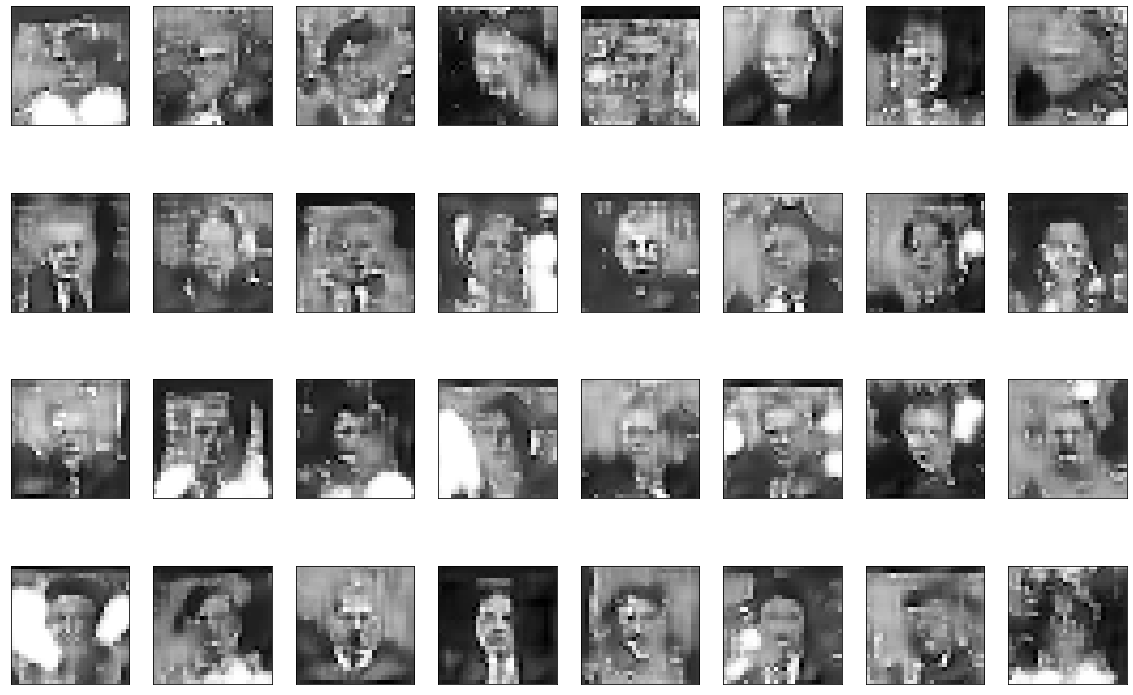

In [14]:
noise = np.random.normal(0, 1, (32, INPUT_DIM)).astype(np.float32)
syntetic_images = generator.predict(noise)
plot_pics(syntetic_images)

## Интерполяция в латентном пространстве

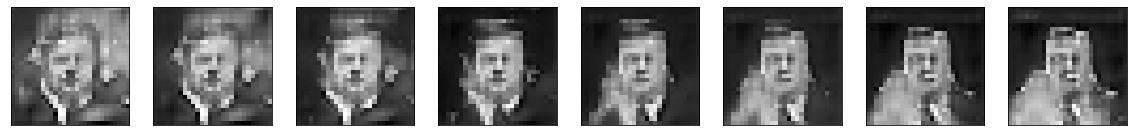

In [15]:
noise_1 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise_2 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise = np.linspace(noise_1, noise_2, 8)
syntetic_images = generator.predict(noise)
plot_pics(syntetic_images)